In [1]:
#!pip install unidecode

In [2]:
import tensorflow as tf

In [3]:
import numpy as np

In [4]:
from tensorflow import keras

In [5]:
import pandas as pd

In [6]:
import string

In [7]:
from unidecode import unidecode

In [8]:
import nltk

In [9]:
from nltk.util import ngrams

In [10]:
from nltk.corpus import stopwords

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
filmes = pd.read_csv("../../dados/imdb-reviews-pt-br.csv", encoding="utf-8")

In [16]:
filmes.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [17]:
# Remover colunas inúteis
filmes.drop(
    columns = ["text_en"],
    inplace = True
)

In [18]:
# Remover linhas com conteudo N/A
filmes.dropna(inplace = True)

In [19]:
filmes = filmes.assign(sentiment_value = [1 if i == 'pos' else 0  for i in filmes["sentiment"]])

In [20]:
# Função para preparar as palavras do texto
def preparar_texto( texto ):
    # Converter em minusculo
    texto_limpo = texto.lower()
    # Remover pontuação e caracteres especiais
    translator = str.maketrans('\n\r\t', '   ', string.punctuation)
    texto_limpo = texto_limpo.translate(translator)
    # Remover os acentos
    texto_limpo = unidecode(texto_limpo)
    return texto_limpo

In [21]:
# Remover Stopwords
stop_words = stopwords.words('portuguese')
def remove_stopwords( texto ):
    tokens = []
    for token in nltk.tokenize.word_tokenize(texto, language='portuguese'):
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

In [22]:
# Stemming
stemmer = nltk.RSLPStemmer()
def stemmer_text( texto ):
    if isinstance(texto, str):
        lista_palavras = texto.split(" ")
        nova_lista = []
        for palavra in lista_palavras:
            stemmed = stemmer.stem( palavra )
            nova_lista.append(stemmed)
        return " ".join(nova_lista)
    else:
        return texto

In [23]:
def transformar_texto( texto ):
    texto_limpo = preparar_texto( texto )
    # texto_sem_stopwords = remove_stopwords(texto_limpo)
    # texto_stemmed = stemmer_text(texto_sem_stopwords)
    # return texto_stemmed
    return texto_limpo

In [24]:
count = 0
def invocar_transformar_texto( texto ):
    global count
    count += 1
    if count % 1000 == 0:
        print(f"Analisando linha: {count} / {filmes.shape[0]}")
    return transformar_texto( texto )

texto_preparado = filmes["text_pt"].apply(invocar_transformar_texto)

Analisando linha: 1000 / 49459
Analisando linha: 2000 / 49459
Analisando linha: 3000 / 49459
Analisando linha: 4000 / 49459
Analisando linha: 5000 / 49459
Analisando linha: 6000 / 49459
Analisando linha: 7000 / 49459
Analisando linha: 8000 / 49459
Analisando linha: 9000 / 49459
Analisando linha: 10000 / 49459
Analisando linha: 11000 / 49459
Analisando linha: 12000 / 49459
Analisando linha: 13000 / 49459
Analisando linha: 14000 / 49459
Analisando linha: 15000 / 49459
Analisando linha: 16000 / 49459
Analisando linha: 17000 / 49459
Analisando linha: 18000 / 49459
Analisando linha: 19000 / 49459
Analisando linha: 20000 / 49459
Analisando linha: 21000 / 49459
Analisando linha: 22000 / 49459
Analisando linha: 23000 / 49459
Analisando linha: 24000 / 49459
Analisando linha: 25000 / 49459
Analisando linha: 26000 / 49459
Analisando linha: 27000 / 49459
Analisando linha: 28000 / 49459
Analisando linha: 29000 / 49459
Analisando linha: 30000 / 49459
Analisando linha: 31000 / 49459
Analisando linha:

In [25]:
def gerar_dicionario( column, dicionario_inicial = {}, initial_counter = 0 ):
    new_column = []
    word_count = initial_counter
    for cell in column:
        new_cell = []
        for palavra in cell.split(" "):
            if palavra not in dicionario_inicial:
                dicionario_inicial[palavra] = word_count
                word_count += 1
            new_cell.append(dicionario_inicial[palavra])
        new_column.append(new_cell)
    return new_column, dicionario_inicial

In [26]:
# Um dicionário mapeando palavras em índices inteiros
word_indices = {}
word_indices["<PAD>"] = 0
word_indices["<START>"] = 1
word_indices["<UNK>"] = 2  # unknown
word_indices["<UNUSED>"] = 3
coluna_indices, dicionario = gerar_dicionario(texto_preparado, word_indices, initial_counter=4)

In [27]:
# Os primeiros índices são reservados
reverse_word_index = dict([(value, key) for (key, value) in dicionario.items()])
def decode_review(text_indices):
    return ' '.join([reverse_word_index.get(i, '?') for i in text_indices])

def encode_review(text):
    lista = [dicionario.get(i, 2) for i in text.split(" ")]
    lista.insert(0, 1)
    return lista

In [28]:
texto_preparado[0]

'mais uma vez o sr costner arrumou um filme por muito mais tempo do que o necessario alem das terriveis sequencias de resgate no mar das quais ha muito poucas eu simplesmente nao me importei com nenhum dos personagens a maioria de nos tem fantasmas no armario e o personagem costers e realizado logo no inicio e depois esquecido ate muito mais tarde quando eu nao me importava o personagem com o qual deveriamos nos importar e muito arrogante e superconfiante ashton kutcher o problema e que ele sai como um garoto que pensa que e melhor do que qualquer outra pessoa ao seu redor e nao mostra sinais de um armario desordenado seu unico obstaculo parece estar vencendo costner finalmente quando estamos bem alem do meio do caminho costner nos conta sobre os fantasmas dos kutchers somos informados de por que kutcher e levado a ser o melhor sem pressentimentos ou pressagios anteriores nenhuma magica aqui era tudo que eu podia fazer para nao desligar uma hora'

In [29]:
list_codes = texto_preparado.apply(encode_review)

In [30]:
decode_review( list_codes[0] )

'<START> mais uma vez o sr costner arrumou um filme por muito mais tempo do que o necessario alem das terriveis sequencias de resgate no mar das quais ha muito poucas eu simplesmente nao me importei com nenhum dos personagens a maioria de nos tem fantasmas no armario e o personagem costers e realizado logo no inicio e depois esquecido ate muito mais tarde quando eu nao me importava o personagem com o qual deveriamos nos importar e muito arrogante e superconfiante ashton kutcher o problema e que ele sai como um garoto que pensa que e melhor do que qualquer outra pessoa ao seu redor e nao mostra sinais de um armario desordenado seu unico obstaculo parece estar vencendo costner finalmente quando estamos bem alem do meio do caminho costner nos conta sobre os fantasmas dos kutchers somos informados de por que kutcher e levado a ser o melhor sem pressentimentos ou pressagios anteriores nenhuma magica aqui era tudo que eu podia fazer para nao desligar uma hora'

In [31]:
list_codes_pad = keras.preprocessing.sequence.pad_sequences(list_codes,
                                                        value=dicionario["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

In [32]:
print(list_codes_pad[0])

[  1   4   5   6   7   8   9  10  11  12  13  14   4  15  16  17   7  18
  19  20  21  22  23  24  25  26  20  27  28  14  29  30  31  32  33  34
  35  36  37  38  39  40  23  41  42  43  25  44  45   7  46  47  45  48
  49  25  50  45  51  52  53  14   4  54  55  30  32  33  56   7  46  35
   7  57  58  41  59  45  14  60  45  61  62  63   7  64  45  17  65  66
  67  11  68  17  69  17  45  70  16  17  71  72  73  74  75  76  45  32
  77  78  23  11  44  79  75  80  81  82  83  84   9  85  55  86  87  19
  16  88  16  89   9  41  90  91  92  43  37  93  94  95  23  13  17  63
  45  96  39  97   7  70  98  99 100 101 102 103 104 105 106 107  17  30
 108 109 110  32 111   5 112   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [44]:
# O formato de entrada é a contagem vocabulário usados pelas avaliações dos filmes (10000 palavras)
vocab_size = len(dicionario)

model1= keras.Sequential()
model1.add(keras.layers.Input(shape=(256, ), dtype='int32', name="Layer_Input"))
model1.add(keras.layers.Dense(units=64, activation='relu', name="Layer_0"))
model1.add(keras.layers.Dense(units=16, activation='relu', name="Layer_1"))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

model2= keras.Sequential()
model2.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=64))
model2.add(keras.layers.GlobalAveragePooling1D())
model2.add(keras.layers.Dense(64, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model = model2

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [45]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
train_X, test_X, train_Y, test_Y = train_test_split(list_codes_pad, filmes["sentiment_value"],
                                                    test_size=0.25, random_state=50)

In [58]:
fit = model.fit(train_X,
                    train_Y,
                    epochs=40,
                    batch_size=512,
                    verbose=1)

Epoch 1/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9992 - loss: 0.0051
Epoch 2/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9995 - loss: 0.0042
Epoch 3/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9990 - loss: 0.0051
Epoch 4/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9970 - loss: 0.0122
Epoch 5/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9977 - loss: 0.0106
Epoch 6/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9995 - loss: 0.0043
Epoch 7/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9997 - loss: 0.0032
Epoch 8/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9998 - loss: 0.0032
Epoch 9/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.9998 - loss: 0.0028
Epoch 10/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.9996 - loss: 0.0028
Epoch 11/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.9993 - loss: 0.0041
Epoch 12/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accu

In [59]:
results = model.evaluate(test_X,  test_Y, verbose=2)

print(results)

387/387 - 1s - 3ms/step - accuracy: 0.8801 - loss: 0.5358
[0.5358368158340454, 0.8801455497741699]


In [60]:
fit.history.keys()

dict_keys(['accuracy', 'loss'])

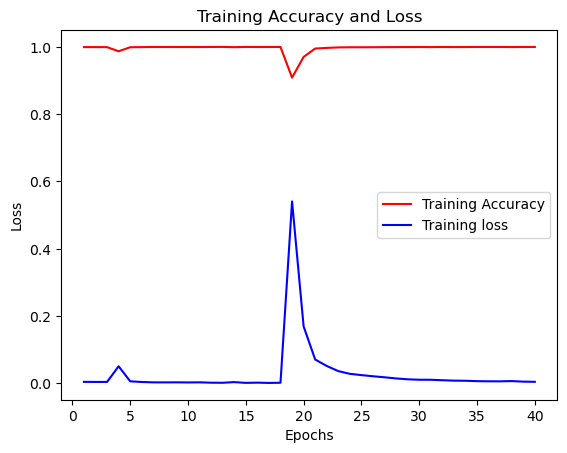

In [61]:
import matplotlib.pyplot as plt

acc = fit.history['accuracy']
loss = fit.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r-', label='Training Accuracy')
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.title('Training Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()